Installing packages that are not in the colab

In [1]:
!sudo pip install tensorflow --upgrade
!pip install -q -U tensorflow-text
!pip install -q tf-models-official


     |████████████████████████████████| 462 kB 5.5 MB/s 
     |████████████████████████████████| 4.9 MB 5.4 MB/s 
     |████████████████████████████████| 2.2 MB 5.3 MB/s 
     |████████████████████████████████| 47.8 MB 1.4 MB/s 
     |████████████████████████████████| 234 kB 46.1 MB/s 
     |████████████████████████████████| 1.2 MB 38.3 MB/s 
     |████████████████████████████████| 1.1 MB 42.6 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 636 kB 10.3 MB/s 
     |████████████████████████████████| 90 kB 5.6 MB/s 
     |████████████████████████████████| 352 kB 33.6 MB/s 
     |████████████████████████████████| 99 kB 4.2 MB/s 


Importing Necessary Packages



In [2]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from official.nlp import optimization  # to create AdamW optimizer
import tensorflow_hub as hub
import tensorflow_text as text
from keras import regularizers
import json
import re
import random
import numpy as np
import matplotlib.pyplot as plt
import pickle


Mounting Colab to drive so that we can load/save data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_path = "/content/drive/My Drive/datasets/"

In [5]:
model_save_path = "/content/drive/My Drive/demo-models/"

In [6]:
save_path = "/content/drive/My Drive/Colab Notebooks/"

Checking if we have an access to gpu

In [7]:
%tensorflow_version 2.x
'''device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))'''

"device_name = tf.test.gpu_device_name()\nif device_name != '/device:GPU:0':\n  raise SystemError('GPU device not found')\nprint('Found GPU at: {}'.format(device_name))"

In [13]:

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

# Project Idea & Insights (Bug Assignee Recommendation)

 Software Analytics aims to make software developers life easier with building software tools, developing heuristic/ml/dl models using software artifacts (e.g. source code, software repositories, feature specifications, issue/bug reports, test cases, execution traces/logs, and real-world user feedback). To have a better understanding, you may refer to the link (https://www.microsoft.com/en-us/research/group/software-analytics/), it is a short but well-defined description of Software Analytics. The idea behind the project is on bug report assignee recommendation. One of the most famous bug report tools is JIRA, and there are many open source project data available (e.g. https://issues.apache.org/jira/projects/). I chose Apache Kafka as the dataset, it is an open-source distributed event streaming platform, commonly used by Data Engineers. A bug report consists of several fields (Description, Assignee, Reporter, Status, Priority, Resolution, Affects Version/s, Fix Version/s, Component/s) and many more. A bug description is a text field that information related with the bug is defined and an assignee is a developer who is usually assigned by a Team Lead and responsible for fixing that bug. The main idea behind the project is to predict an assignee to a bug report by using its' bug description. This project can be helpful for Software Team Leads while assigning bugs to Software Developers in a team.

# Data Loading & Preprocessing

Reading Bug Assignee data with bug descriptions and assignees

In [8]:
with open(data_path+'project_data.json') as f:
    data = json.load(f)
    # create description and assignee list
    desc_data = []
    assignee_data = []
    for item in data:
        desc_data.append(item['description'])
        assignee_data.append(item['assignee'])

 Transform description data to tensorflow dataset

In [9]:

descriptions = tf.data.Dataset.from_tensor_slices(desc_data)

*   I have mapped original names to fake names, so that I don't process any personal data.
*   Cell below creates assignee dictionary with id's so that we can feed into neural networks & also can revert predictions (id's) to assignee by names.

In [11]:
assignee_dict = {assignee: i for i, assignee in enumerate(list(set(assignee_data)))}
assignee_dict

{'Alex': 0,
 'Alice': 6,
 'Anna': 8,
 'Barbara': 3,
 'Bob': 34,
 'Brandon': 28,
 'Charlie': 11,
 'David': 35,
 'Debra': 7,
 'Eric': 30,
 'George': 12,
 'Henry': 22,
 'Isabella': 23,
 'Jan': 29,
 'Jennifer': 31,
 'Joe': 33,
 'Johannes': 20,
 'Julia': 18,
 'Lawrence': 9,
 'Linda': 17,
 'Lisa': 15,
 'Maria': 32,
 'Mary': 16,
 'Matthew': 1,
 'Melissa': 10,
 'Natalie': 19,
 'Patricia': 21,
 'Peter': 26,
 'Richard': 2,
 'Russell': 13,
 'Sara': 5,
 'Sophia': 24,
 'Steven': 4,
 'Thomas': 27,
 'Tom': 25,
 'Vanessa': 14}

Saving assignee dictionary to a json file so that in the demo notebook we can remap predictions (id's) to fake names 

In [12]:
'''with open(data_path + 'assignee_dict.json', 'w') as fp:
    json.dump(assignee_dict, fp)'''

Creating a target vector with id's

In [15]:
assignee_vector = [assignee_dict[assignee] for assignee in assignee_data]
assignee_vector[:10]

[12, 23, 4, 27, 3, 18, 3, 2, 34, 14]

Assignee target vector to one hot vector

In [17]:
assignee_tensor = tf.data.Dataset.from_tensor_slices(assignee_vector)
assignee_one_hot = assignee_tensor.map(lambda x: tf.one_hot(x, len(assignee_dict)))

Zip descriptions and assignee for training

In [18]:
dataset = tf.data.Dataset.zip((descriptions, assignee_one_hot))

Shuffle dataset, set reshuffle_each_iteration=False as this defaults to True and then splits will be different per epoch.


In [19]:
data_len = len(dataset)
dataset = dataset.shuffle(data_len, seed = 42, reshuffle_each_iteration = False)

Split dataset into train validation and test dataset batch size is 32 and validation and test size is 15%

In [20]:

BATCH_SIZE = 32
VAL_SIZE = 0.15
n_examples = tf.data.experimental.cardinality(dataset).numpy()

VAL_SIZE = round(VAL_SIZE*n_examples)
test_dataset = dataset.take(VAL_SIZE).batch(batch_size=BATCH_SIZE, drop_remainder=True)
val_dataset = dataset.skip(VAL_SIZE).take(VAL_SIZE).batch(batch_size=BATCH_SIZE, drop_remainder=True)
train_dataset = dataset.skip(VAL_SIZE*2).batch(batch_size=BATCH_SIZE, drop_remainder=True)

Prefetch train val and test dataset

In [21]:

train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

print('len(train_dataset): # of batches', len(train_dataset))
print('len(val_dataset): # of batches', len(val_dataset))
print('len(test_dataset): # of batches', len(test_dataset))

len(train_dataset): # of batches 138
len(val_dataset): # of batches 29
len(test_dataset): # of batches 29


Train dataset examples

In [22]:

for input, target in train_dataset.take(1):
    print(input)
    print(target)

tf.Tensor(
[b'Saw the following stacktrace kafka network thread prio tid fce nid xeefa runnable eef java lang Thread State RUNNABLE at sun nio ch KQueueArrayWrapper kevent Native Method at sun nio ch KQueueArrayWrapper poll KQueueArrayWrapper java at sun nio ch KQueueSelectorImpl doSelect KQueueSelectorImpl java at sun nio ch SelectorImpl lockAndDoSelect SelectorImpl java locked fa a sun nio ch Util locked fa a java util Collections UnmodifiableSet locked fa a sun nio ch KQueueSelectorImpl at sun nio ch SelectorImpl select SelectorImpl java at kafka network Processor run SocketServer scala at java lang Thread run Thread java Test worker prio tid fced nid xc waiting on condition java lang Thread State WAITING parking at sun misc Unsafe park Native Method parking to wait for fad a java util concurrent CountDownLatch Sync at java util concurrent locks LockSupport park LockSupport java at java util concurrent locks AbstractQueuedSynchronizer parkAndCheckInterrupt AbstractQueuedSynchronizer

# Bag-of-Words Implementation

Creating input vectorizer so that given a string vectorizer maps it to a bag of words vector 

In [24]:
input_vectorizer = layers.TextVectorization(
    split = "whitespace",
    standardize = 'lower_and_strip_punctuation',
    output_mode='multi_hot')

Adapting input vectorizer with our datasets, vectorizer learns the vocabulary from the dataset 

In [25]:
input_vectorizer.adapt(descriptions)

Our vocabulary consists of 13897 words

In [26]:
len(input_vectorizer.get_vocabulary())

13897

Pickle the config and weights

In [48]:
 
'''
pickle.dump({'config': input_vectorizer.get_config(),
             'weights': input_vectorizer.get_weights()}
            , open(save_path + "input_vectorizer.pkl", "wb"))
'''

An example of input vectorizer with a description and it's vectorizer result

In [31]:
for description in descriptions.take(2):
    print(description)
    print(input_vectorizer(description))

tf.Tensor(b'code java java util concurrent ExecutionException org apache kafka common errors UnknownTopicOrPartitionException This server does not host this topic partition at org apache kafka common internals KafkaFutureImpl wrapAndThrow KafkaFutureImpl java at org apache kafka common internals KafkaFutureImpl access KafkaFutureImpl java at org apache kafka common internals KafkaFutureImpl SingleWaiter await KafkaFutureImpl java at org apache kafka common internals KafkaFutureImpl get KafkaFutureImpl java at kafka api SaslSslAdminClientIntegrationTest testCreateTopicsResponseMetadataAndConfig SaslSslAdminClientIntegrationTest scala at sun reflect NativeMethodAccessorImpl invoke Native Method at sun reflect NativeMethodAccessorImpl invoke NativeMethodAccessorImpl java at sun reflect DelegatingMethodAccessorImpl invoke DelegatingMethodAccessorImpl java at java lang reflect Method invoke Method java at org junit runners model FrameworkMethod runReflectiveCall FrameworkMethod java at org 

Vectorizing whole dataset (descriptions, assignees) so that we can feed it into neural networks

In [32]:
def vectorize_dataset(description, assignee):

  return input_vectorizer(description), assignee

bow_train_dataset = train_dataset.map(vectorize_dataset)
bow_val_dataset = val_dataset.map(vectorize_dataset)
bow_test_dataset = test_dataset.map(vectorize_dataset)
for description, assignee in bow_train_dataset.take(1):
    print(description, assignee)

tf.Tensor(
[[0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]], shape=(32, 13897), dtype=float32) tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(32, 36), dtype=float32)


Creating early stopping to prevent overfitting to training data

In [51]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

Very simple bag of words model that consists of one hidden layer with 64 nodes, one dropout layer and one prediction layer

In [52]:
vocab_size = input_vectorizer.vocabulary_size()
bow_model = tf.keras.Sequential([
  tf.keras.layers.Dense(64, kernel_regularizer=regularizers.l2(0.05),input_shape=(vocab_size,), activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(len(assignee_dict), activation = "softmax")
])

Compiling bow_model with an optimizer, loss and metric

In [53]:
bow_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics = tf.keras.metrics.CategoricalAccuracy()
)

Summary of bow_model

In [54]:
bow_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                889472    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 36)                2340      
                                                                 
Total params: 891,812
Trainable params: 891,812
Non-trainable params: 0
_________________________________________________________________


Training bow_model

In [55]:
bow_model.fit(
    bow_train_dataset,
    validation_data=bow_val_dataset,
    epochs=20,
    callbacks=[tensorboard_callback,callback])

Epoch 1/20
138/138 [==============================] - 2s 8ms/step - loss: 5.6613 - categorical_accuracy: 0.0856 - val_loss: 3.8136 - val_categorical_accuracy: 0.0916
Epoch 2/20
138/138 [==============================] - 1s 7ms/step - loss: 3.5359 - categorical_accuracy: 0.1259 - val_loss: 3.4232 - val_categorical_accuracy: 0.1110
Epoch 3/20
138/138 [==============================] - 1s 8ms/step - loss: 3.3731 - categorical_accuracy: 0.1510 - val_loss: 3.3744 - val_categorical_accuracy: 0.1659
Epoch 4/20
138/138 [==============================] - 1s 8ms/step - loss: 3.3469 - categorical_accuracy: 0.1655 - val_loss: 3.3545 - val_categorical_accuracy: 0.1886
Epoch 5/20
138/138 [==============================] - 3s 19ms/step - loss: 3.3341 - categorical_accuracy: 0.1800 - val_loss: 3.3380 - val_categorical_accuracy: 0.1789
Epoch 6/20
138/138 [==============================] - 1s 8ms/step - loss: 3.3283 - categorical_accuracy: 0.1873 - val_loss: 3.3294 - val_categorical_accuracy: 0.1886
Epo

Testing bow_model on test dataset

In [56]:
loss, accuracy = bow_model.evaluate(bow_test_dataset)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

29/29 [==============================] - 0s 4ms/step - loss: 3.2011 - categorical_accuracy: 0.2683
Loss: 3.2010693550109863
Accuracy: 0.26831895112991333


Saving bow_model to reload and use in demo notebook

In [57]:
saved_model_path = model_save_path + '/bow_model_3'

In [58]:
bow_model.save(saved_model_path)

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks//bow_model_3/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks//bow_model_3/assets


# bidirectional LSTM (BiLSTM) with recurrent neural network (RNN) architecture

Initialize a TextVectorization layer for word embedding with the desired parameters

In [35]:
VOCAB_SIZE = 10000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Some examples from vocabulary

In [36]:
vocab = np.array(encoder.get_vocabulary())
vocab[:100]

array(['', '[UNK]', 'the', 'to', 'kafka', 'a', 'at', 'is', 'in', 'java',
       'and', 'of', 'org', 'this', 'we', 'apache', 'for', 'it', 'that',
       'scala', 'be', 'not', 'consumer', 'with', 'topic', 'on', 'code',
       'are', 'if', 'when', 'i', 'as', 'from', 'test', 'log', 'will',
       'streams', 'should', 'error', 'producer', 'can', 'broker', 'have',
       'but', 'partition', 'an', 'https', 'new', 'by', 'which', 's', 't',
       'server', 'clients', 'thread', 'all', 'state', 'connect', 'or',
       'request', 'message', 'internals', 'offset', 'there', 'common',
       'would', 'junit', 'one', 'time', 'config', 'was', 'lang', 'some',
       'group', 'use', 'so', 'partitions', 'only', 'run', 'data',
       'currently', 'com', 'kip', 'has', 'client', 'since', 'api',
       'messages', 'exception', 'class', 'no', 'leader', 'assert', 'id',
       'collection', 'after', 'topics', 'value', 'using', 'following'],
      dtype='<U255')

Initializing BiLSTM model with using two bidirectional LSTM layers

In [37]:
rnn_model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.2, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=0.2)),
    tf.keras.layers.Dense(len(assignee_dict))
])

RNN with BiLSTM model Summary

In [68]:
print(rnn_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, None, 64)          640000    
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 36)                2340      
                                                      

Compiling RNN model with BiLSTM layers

In [69]:
rnn_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [70]:
history = rnn_model.fit(train_dataset, epochs=20,
                    validation_data=val_dataset,
                    callbacks = [callback])

Epoch 1/20
138/138 [==============================] - 44s 184ms/step - loss: 3.4225 - accuracy: 0.0913 - val_loss: 3.3631 - val_accuracy: 0.1110
Epoch 2/20
138/138 [==============================] - 20s 144ms/step - loss: 3.0565 - accuracy: 0.1667 - val_loss: 3.0287 - val_accuracy: 0.1735
Epoch 3/20
138/138 [==============================] - 20s 144ms/step - loss: 2.4920 - accuracy: 0.3030 - val_loss: 2.8134 - val_accuracy: 0.2338
Epoch 4/20
138/138 [==============================] - 20s 145ms/step - loss: 1.9975 - accuracy: 0.4380 - val_loss: 2.6902 - val_accuracy: 0.2802
Epoch 5/20
138/138 [==============================] - 20s 144ms/step - loss: 1.5897 - accuracy: 0.5587 - val_loss: 2.6146 - val_accuracy: 0.3438
Epoch 6/20
138/138 [==============================] - 20s 143ms/step - loss: 1.2722 - accuracy: 0.6445 - val_loss: 2.7120 - val_accuracy: 0.3750
Epoch 7/20
138/138 [==============================] - 20s 145ms/step - loss: 0.9935 - accuracy: 0.7271 - val_loss: 2.6321 - val_ac

Evaluating our RNN model with BiLSTM layers on test dataset

In [71]:
loss, accuracy = rnn_model.evaluate(test_dataset)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

29/29 [==============================] - 2s 52ms/step - loss: 2.5828 - accuracy: 0.4138
Loss: 2.582845449447632
Accuracy: 0.4137931168079376


Saving the model

In [72]:
saved_model_path = model_save_path + '/rnn_model_3'

In [73]:
rnn_model.save(saved_model_path)

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks//rnn_model_3/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks//rnn_model_3/assets


# BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding

Selecting BERT and preprocess model from [TensorFlow Hub](https://www.tensorflow.org/hub). I preferred the simpler one with _L-2_H-128_A-2, which means 2 layers, 128 dim representations and 2 Attention heads. 

In [74]:
bert_model_name = 'small_bert/bert_en_uncased_L-2_H-128_A-2' 

map_name_to_handle = {
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'}

map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'}

# find more models and preprocessing maps at 
# https://www.tensorflow.org/text/tutorials/classify_text_with_bert?hl=en

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')


bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


Preprocessing examples

In [75]:

text_test = [input[0].numpy(), input[1].numpy()]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Lines      : {text_test}')
print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   :')
print(f'{text_preprocessed["input_word_ids"][:, :12]}')
print(f'Input Mask :')
print(f'{text_preprocessed["input_mask"][:, :12]}')
print(f'Type Ids   :')
print(f'{text_preprocessed["input_type_ids"][:, :12]}')

Lines      : [b'Saw the following stacktrace kafka network thread prio tid fce nid xeefa runnable eef java lang Thread State RUNNABLE at sun nio ch KQueueArrayWrapper kevent Native Method at sun nio ch KQueueArrayWrapper poll KQueueArrayWrapper java at sun nio ch KQueueSelectorImpl doSelect KQueueSelectorImpl java at sun nio ch SelectorImpl lockAndDoSelect SelectorImpl java locked fa a sun nio ch Util locked fa a java util Collections UnmodifiableSet locked fa a sun nio ch KQueueSelectorImpl at sun nio ch SelectorImpl select SelectorImpl java at kafka network Processor run SocketServer scala at java lang Thread run Thread java Test worker prio tid fced nid xc waiting on condition java lang Thread State WAITING parking at sun misc Unsafe park Native Method parking to wait for fad a java util concurrent CountDownLatch Sync at java util concurrent locks LockSupport park LockSupport java at java util concurrent locks AbstractQueuedSynchronizer parkAndCheckInterrupt AbstractQueuedSynchroniz

Model output examples before training with our dataset

In [76]:


bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2
Sequence Outputs Shape:(2, 128, 128)
Sequence Outputs Values:[[-0.7978706  -0.39245942 -3.112212   ... -1.196876   -1.7813495
   0.89129806]
 [-1.0537355  -0.27181557  0.3092998  ... -1.6049153  -3.1087265
   0.96863866]
 [-1.3172263   0.6885311   0.11612162 ... -1.9693499  -1.795817
   0.73868644]
 ...
 [-0.07454477  0.3055162   0.5694753  ... -2.7664793  -0.6082494
   1.6092896 ]
 [-0.1131182  -0.06081036  0.34595737 ... -2.9312954  -2.263903
   2.9446657 ]
 [ 0.52549523 -0.61103     0.01515445 ... -2.4205444  -2.1981342
   1.6228845 ]]
Pooled Outputs Shape:(2, 128)
Pooled Outputs Values:[-0.99925137  0.09567033  0.4052936  -0.725472   -0.53752947  0.05948785
 -0.02080893 -0.8750553  -0.03955572  0.2193361   0.64436907  0.02810927]


BERT classifier Model

In [77]:
def build_bert_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output'] 
  net = tf.keras.layers.Dropout(0.5, name = 'dropout_1')(net)
  net = tf.keras.layers.Dense(len(assignee_dict), activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

Building the classifier and its summary

In [78]:


bert_bug_assignee_classifier = build_bert_classifier_model()

bert_bug_assignee_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

Classifier output examples before training

In [79]:


bert_raw_result = bert_bug_assignee_classifier(tf.constant(text_test))
print(tf.nn.softmax(bert_raw_result))

tf.Tensor(
[[0.00461664 0.07849946 0.01016529 0.01397957 0.01025757 0.01672038
  0.00616649 0.0613345  0.01570095 0.00954723 0.01022766 0.01668776
  0.0139678  0.02163674 0.01842308 0.00338146 0.00806365 0.03490677
  0.01189775 0.06619357 0.01798718 0.05329616 0.02640694 0.05112782
  0.01086289 0.07753524 0.01285555 0.10941197 0.0191719  0.00705469
  0.08049639 0.01318844 0.04913106 0.01021915 0.00930987 0.0195704 ]
 [0.00705634 0.02845198 0.0245383  0.02295719 0.04416997 0.01461216
  0.00628969 0.09558216 0.01008123 0.01466828 0.02309811 0.01269863
  0.01995655 0.01190472 0.00750264 0.01272508 0.0160588  0.03536161
  0.00775232 0.12998621 0.00659966 0.04150823 0.05348043 0.0212934
  0.03240777 0.01298452 0.0223408  0.06290666 0.03599936 0.01287823
  0.05152658 0.01477064 0.01505962 0.02538559 0.02499449 0.02041201]], shape=(2, 36), dtype=float32)


Plotting the BERT model

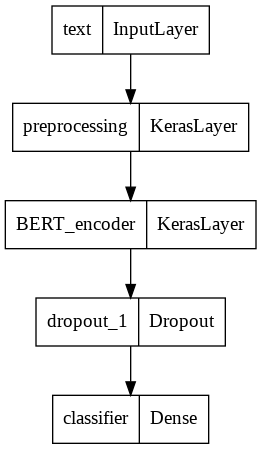

In [80]:

tf.keras.utils.plot_model(bert_bug_assignee_classifier)

Creating optimizer, loss, metrics and then compiling the BERT classifier

In [81]:
epochs = 15
steps_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs

# Here we are using AdamW with a linear learning rate schedule.
# Because of the rolling averages in the optimization logic we need a few warm up steps.
warmup_ratio = 0.1
num_warmup_steps = int(warmup_ratio*num_train_steps)
init_lr = 1e-3

print('steps per epoch',steps_per_epoch)
print('num train',num_train_steps)
print('num warmup',num_warmup_steps)

optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.CategoricalAccuracy()

# compiling the model
bert_bug_assignee_classifier.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

steps per epoch 138
num train 2070
num warmup 207


Visualizing our learning rate schedule

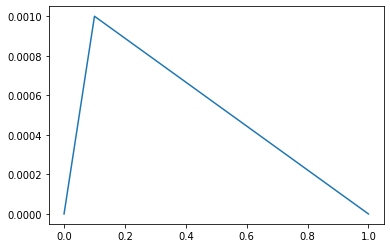

In [82]:

x = np.array([0,warmup_ratio,1])
y = np.array([0, init_lr,0])
plt.plot(x,y)

Training BERT classifier

In [83]:
print(f'Training BERT model with {tfhub_handle_encoder}')
history = bert_bug_assignee_classifier.fit(x=train_dataset,
                               validation_data=val_dataset,
                               epochs=epochs,
                               callbacks = [callback])

Training BERT model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2
Epoch 1/15
138/138 [==============================] - 36s 169ms/step - loss: 3.7539 - categorical_accuracy: 0.0609 - val_loss: 3.3524 - val_categorical_accuracy: 0.1293
Epoch 2/15
138/138 [==============================] - 22s 161ms/step - loss: 3.2892 - categorical_accuracy: 0.1402 - val_loss: 2.9085 - val_categorical_accuracy: 0.1929
Epoch 3/15
138/138 [==============================] - 22s 159ms/step - loss: 2.6979 - categorical_accuracy: 0.2600 - val_loss: 2.5809 - val_categorical_accuracy: 0.2866
Epoch 4/15
138/138 [==============================] - 22s 158ms/step - loss: 1.9967 - categorical_accuracy: 0.4454 - val_loss: 2.2533 - val_categorical_accuracy: 0.4095
Epoch 5/15
138/138 [==============================] - 22s 159ms/step - loss: 1.3819 - categorical_accuracy: 0.6221 - val_loss: 2.1695 - val_categorical_accuracy: 0.4612
Epoch 6/15
138/138 [==============================] - 22s 

Testing the model on test dataset

In [84]:
loss, accuracy = bert_bug_assignee_classifier.evaluate(test_dataset)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

29/29 [==============================] - 3s 105ms/step - loss: 2.2282 - categorical_accuracy: 0.5560
Loss: 2.228231191635132
Accuracy: 0.556034505367279


Saving the model

In [85]:
saved_model_path = model_save_path + '/bert_model_4'

In [86]:
bert_bug_assignee_classifier.save(saved_model_path,include_optimizer=False)

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks//bert_model_4/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks//bert_model_4/assets
